# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

2. I need to edit the levels of the training data so that anything where the signal is greater than 1 (due to high noise), should be normalised to 1

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. run test and get results
5. Write small extract on findings, and put into markdown on github.

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout no-features-results")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
from audioautoencoder.models.UNetConv10mask import *
from audioautoencoder.models.UNetConv4 import *

In [5]:
#!pip install segmentation-models-pytorch

In [6]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet18",      # Lightweight backbone
    encoder_weights=None,         # No pretrained weights since we're not using 3 RGB channels
    in_channels=4,                # 👈 Accept 4-channel input (e.g., stacked spectrograms)
    classes=4                     # 👈 Output 4-channel denoised output
)

## Test Model

In [7]:
BATCH_SIZE = 1
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 4, 1025 // 4, 175))
      model = UNetConv4(in_channels=4, out_channels=4)
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 256, 175])


In [8]:
!pip install torchinfo

In [9]:
from torchinfo import summary

# For example, if the input size is (batch_size=2, channels=9, height=256, width=256):
summary(model, input_size=(2, 4, 1025 // 4, 175))


Layer (type:depth-idx)                   Output Shape              Param #
UNetConv4                                [2, 4, 256, 175]          --
├─Sequential: 1-1                        [2, 16, 122, 82]          --
│    └─Conv2d: 2-1                       [2, 16, 126, 86]          3,152
│    └─BatchNorm2d: 2-2                  [2, 16, 126, 86]          32
│    └─LeakyReLU: 2-3                    [2, 16, 126, 86]          --
│    └─Conv2d: 2-4                       [2, 16, 122, 82]          12,560
│    └─BatchNorm2d: 2-5                  [2, 16, 122, 82]          32
│    └─LeakyReLU: 2-6                    [2, 16, 122, 82]          --
├─Sequential: 1-2                        [2, 32, 58, 38]           --
│    └─Conv2d: 2-7                       [2, 32, 60, 40]           12,832
│    └─BatchNorm2d: 2-8                  [2, 32, 60, 40]           64
│    └─LeakyReLU: 2-9                    [2, 32, 60, 40]           --
│    └─Conv2d: 2-10                      [2, 32, 58, 38]           25,632


## Define Params

In [10]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.serialization.add_safe_globals([UNetConv4])
model = UNetConv4(in_channels=4, out_channels=4).to(device)


print(device)

cuda


In [11]:
i = 0
train = True
LOAD_DATA = True
load_model = True

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv4'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = 'remapped-signal-level' # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 256
num_workers = 12

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512*2)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [12]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [13]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [14]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [15]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)
      combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_no_features(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size,
          num_workers=num_workers
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Training set size: 59767
Validation set size: 14942
Training set size: 59767
Validation set size: 14942


## Inspect Data

In [16]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([4, 256, 175])


9.431421279907227
(4, 256, 175)
(256, 175)
Min, Max:  0.0 1.8240272
(256, 175)
Min, Max:  0.0 1.6934152
(256, 175)
Min, Max:  0.0 1.1163168
(256, 175)
Min, Max:  0.0 1.1283734
Min, Max:  0.0 1.8231642
Min, Max:  0.0 1.2057586
Min, Max:  0.0 1.1157386
Min, Max:  0.0 1.1284956


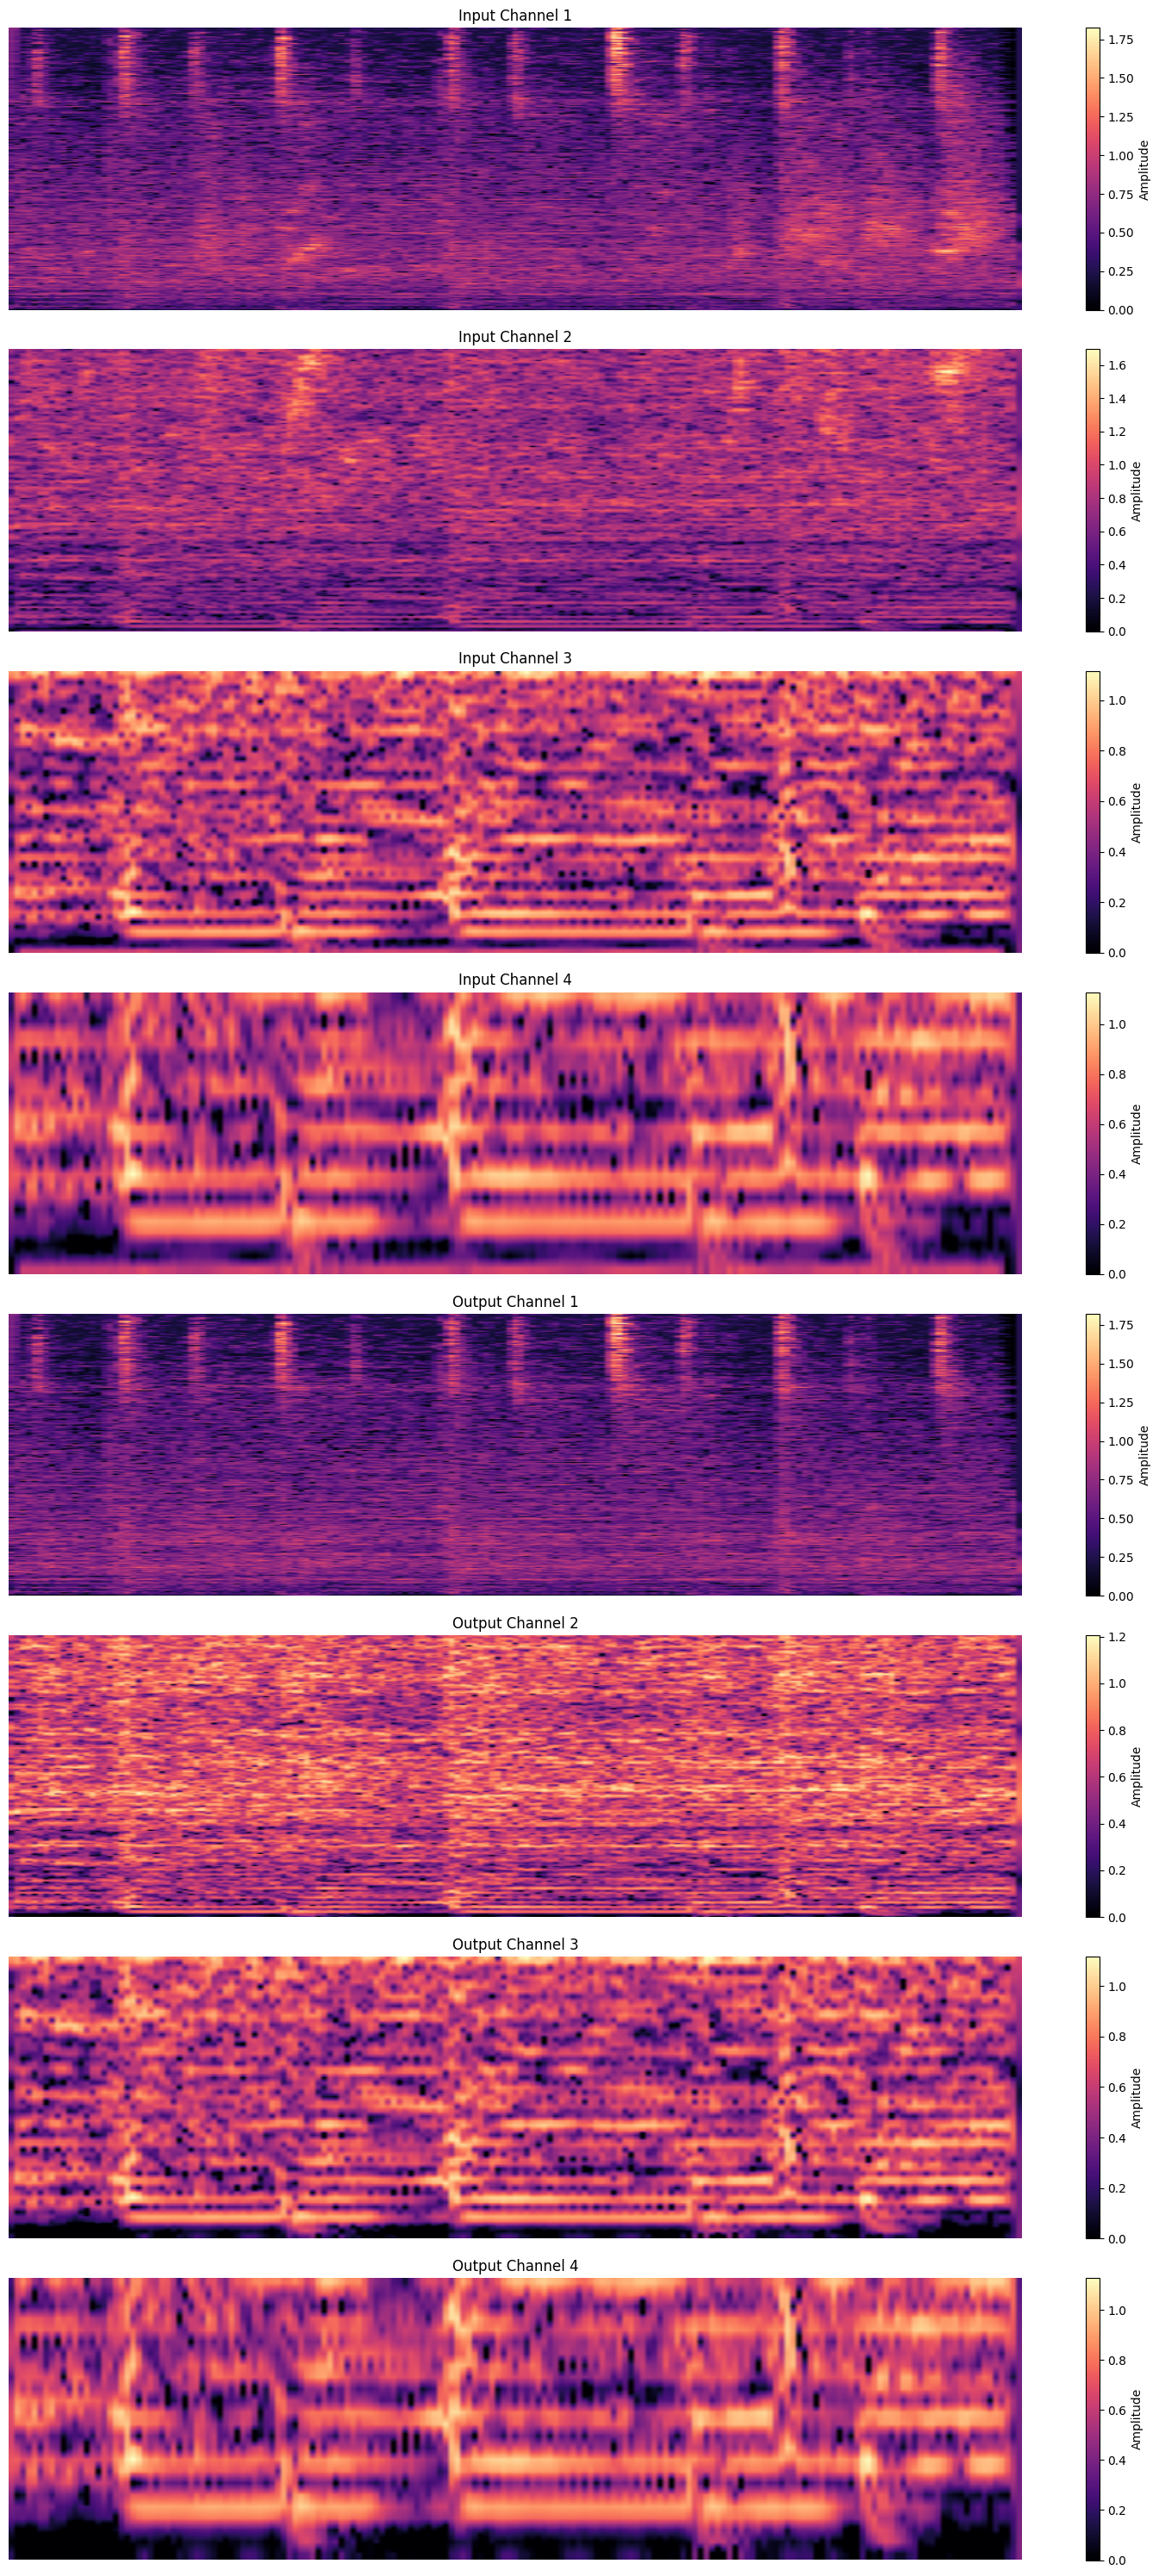

In [17]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[51]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [18]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [19]:
import torch

torch.cuda.empty_cache()

In [20]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [21]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [22]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [23]:
from audioautoencoder.training import *

# plot example inputs



Loading model from: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_checkpoint.pth
Checkpoint keys: dict_keys(['model_state_dict', 'entire_model', 'optimizer_state_dict', 'epoch', 'loss', 'total_epochs'])
Loss: 0.168881356716156, Epoch: 0, Total epochs: 100
Training on device: cuda
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.1


Validating: 100%|██████████| 59/59 [03:34<00:00,  3.63s/batch, loss=joint loss: 0.1544]


--------------------------------------------------
Epoch 1, Validation Loss: 0.1518
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


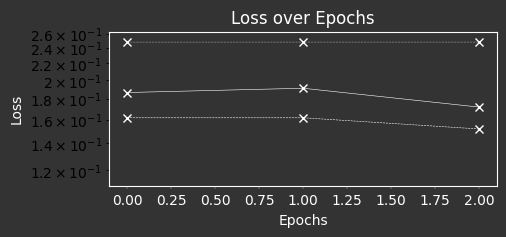

Epoch [1/100], Loss: 0.1718
--------------------------------------------------
Epoch 2, Current Learning Rate: [0.0009046039886902864]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.01
Noise Level:  0.08000000000000002


Validating: 100%|██████████| 59/59 [03:24<00:00,  3.47s/batch, loss=joint loss: 0.1487]


--------------------------------------------------
Epoch 2, Validation Loss: 0.1462
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


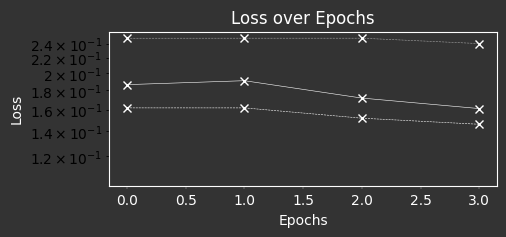

Epoch [2/100], Loss: 0.1610
--------------------------------------------------
Epoch 3, Current Learning Rate: [0.0006548539886902864]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.02
Noise Level:  0.06


Validating: 100%|██████████| 59/59 [03:37<00:00,  3.69s/batch, loss=joint loss: 0.1452]


--------------------------------------------------
Epoch 3, Validation Loss: 0.1452
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


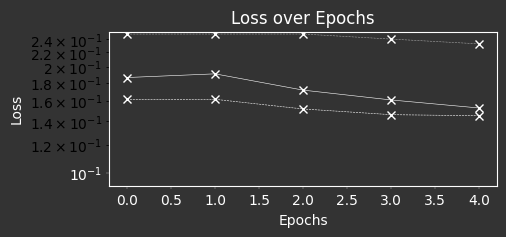

Epoch [3/100], Loss: 0.1527
--------------------------------------------------
Epoch 4, Current Learning Rate: [0.0003461460113097139]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.03
Noise Level:  0.04000000000000001


Validating: 100%|██████████| 59/59 [03:14<00:00,  3.30s/batch, loss=joint loss: 0.1422]


--------------------------------------------------
Epoch 4, Validation Loss: 0.1398
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


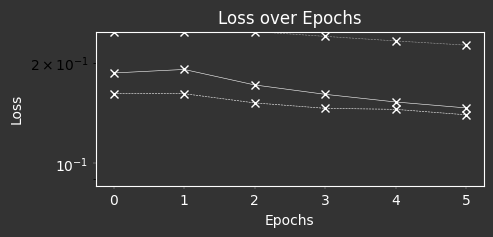

Epoch [4/100], Loss: 0.1466
--------------------------------------------------
Epoch 5, Current Learning Rate: [9.639601130971382e-05]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.04
Noise Level:  0.019999999999999997


Validating: 100%|██████████| 59/59 [03:35<00:00,  3.65s/batch, loss=joint loss: 0.1399]


--------------------------------------------------
Epoch 5, Validation Loss: 0.1375
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


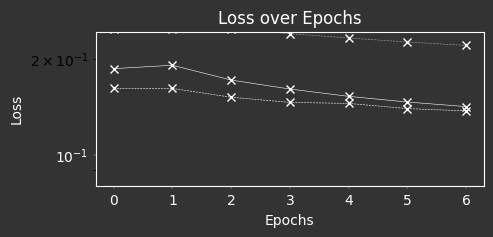

Epoch [5/100], Loss: 0.1419
--------------------------------------------------
Epoch 6, Current Learning Rate: [0.001]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.05
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:19<00:00,  3.38s/batch, loss=joint loss: 0.1417]


--------------------------------------------------
Epoch 6, Validation Loss: 0.1393
EarlyStopping counter: 1 out of 100
Saved to Drive...


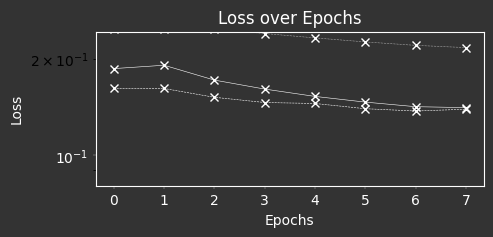

Epoch [6/100], Loss: 0.1409
--------------------------------------------------
Epoch 7, Current Learning Rate: [0.0009755527298894294]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.06
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:23<00:00,  3.45s/batch, loss=joint loss: 0.1379]


--------------------------------------------------
Epoch 7, Validation Loss: 0.1379
EarlyStopping counter: 2 out of 100
Saved to Drive...


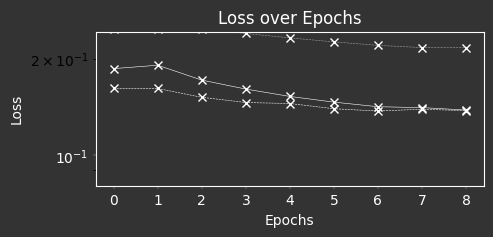

Epoch [7/100], Loss: 0.1385
--------------------------------------------------
Epoch 8, Current Learning Rate: [0.0009046039886902864]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.07
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:33<00:00,  3.62s/batch, loss=joint loss: 0.1354]


--------------------------------------------------
Epoch 8, Validation Loss: 0.1354
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


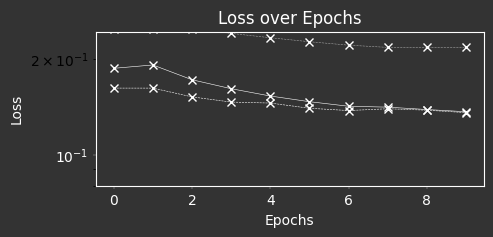

Epoch [8/100], Loss: 0.1363
--------------------------------------------------
Epoch 9, Current Learning Rate: [0.0007940987335200904]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.08
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:36<00:00,  3.67s/batch, loss=joint loss: 0.1345]


--------------------------------------------------
Epoch 9, Validation Loss: 0.1345
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


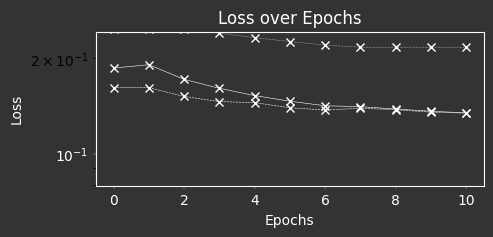

Epoch [9/100], Loss: 0.1347
--------------------------------------------------
Epoch 10, Current Learning Rate: [0.0006548539886902864]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.09
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:34<00:00,  3.63s/batch, loss=joint loss: 0.1373]


--------------------------------------------------
Epoch 10, Validation Loss: 0.1350
EarlyStopping counter: 1 out of 100
Saved to Drive...


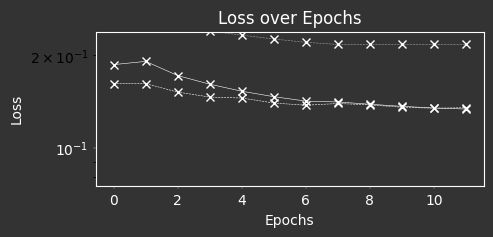

Epoch [10/100], Loss: 0.1337
--------------------------------------------------
Epoch 11, Current Learning Rate: [0.0005005000000000001]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.1
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:57<00:00,  4.03s/batch, loss=joint loss: 0.1326]


--------------------------------------------------
Epoch 11, Validation Loss: 0.1326
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


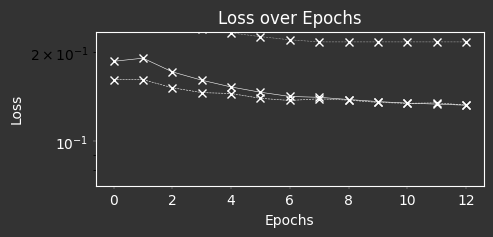

Epoch [11/100], Loss: 0.1325
--------------------------------------------------
Epoch 12, Current Learning Rate: [0.0003461460113097139]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.11
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:35<00:00,  3.65s/batch, loss=joint loss: 0.1306]


--------------------------------------------------
Epoch 12, Validation Loss: 0.1306
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


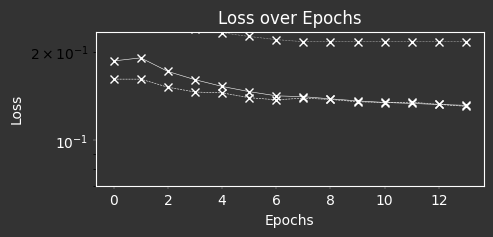

Epoch [12/100], Loss: 0.1316
--------------------------------------------------
Epoch 13, Current Learning Rate: [0.00020690126647990973]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.12
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:43<00:00,  3.79s/batch, loss=joint loss: 0.1318]


--------------------------------------------------
Epoch 13, Validation Loss: 0.1295
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


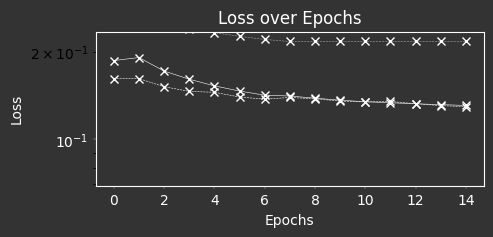

Epoch [13/100], Loss: 0.1308
--------------------------------------------------
Epoch 14, Current Learning Rate: [9.639601130971382e-05]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.13
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:43<00:00,  3.79s/batch, loss=joint loss: 0.1291]


--------------------------------------------------
Epoch 14, Validation Loss: 0.1291
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


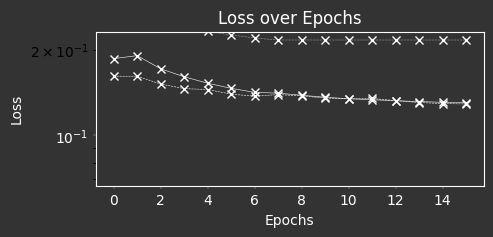

Epoch [14/100], Loss: 0.1303
--------------------------------------------------
Epoch 15, Current Learning Rate: [2.5447270110570814e-05]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.14
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:40<00:00,  3.74s/batch, loss=joint loss: 0.1288]


--------------------------------------------------
Epoch 15, Validation Loss: 0.1288
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


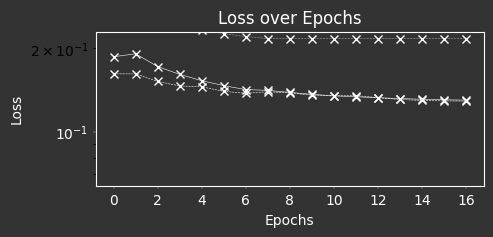

Epoch [15/100], Loss: 0.1299
--------------------------------------------------
Epoch 16, Current Learning Rate: [0.001]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.15
Noise Level:  0.0


Validating: 100%|██████████| 59/59 [03:41<00:00,  3.76s/batch, loss=joint loss: 0.1335]


--------------------------------------------------
Epoch 16, Validation Loss: 0.1312
EarlyStopping counter: 1 out of 100
Saved to Drive...


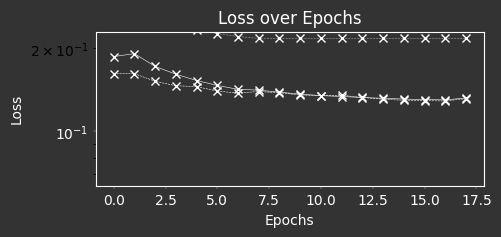

Epoch [16/100], Loss: 0.1320
--------------------------------------------------
Epoch 17, Current Learning Rate: [0.0009938503261272714]


Training:   0%|          | 0/234 [00:00<?, ?batch/s]

New kl loss beta: 0.16
Noise Level:  0.0


Training:  73%|███████▎  | 170/234 [10:33<03:58,  3.73s/batch, loss=loss: 0.1314, ref:0.2170]


KeyboardInterrupt: 

In [24]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.1, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

___